In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import sparse
import json
from datetime import datetime
import warnings

import pcg_skel
from cloudvolume import CloudVolume
from caveclient import CAVEclient

In [2]:
euc_dist_step = 100 * 1000
path_dist_step = 100 * 1000
nsteps = 1000
cache_dir = "..\\data\\"
pre_type = "23P"
max_hist_dist = 2_000_000
num_syns_cutoff = 100
split_quality_cutoff = 0.5
require_in_col = True  # this requires the pre- and post-synaptic cells to be in the proofread column, in which all cells were manually cell-typed
allow_clean = True
inh_cell_types = ["BPC", "BC", "MC", "NGC"]

datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)

In [3]:
# client.auth.get_new_token()  # <-- use this the first time to get a token
# client.auth.save_token( )

## Find a presynaptic cell of type `pre_type` that's been proofread to investigate

In [6]:
all_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")
col_cells = client.materialize.query_table("allen_v1_column_types_v2").query("cell_type != 'Unsure'")
all_cells["num_soma"] = all_cells.groupby("pt_root_id").transform("count")["valid"]
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id
col_cells_by_root = col_cells.copy()
col_cells_by_root.index = col_cells_by_root.pt_root_id
cells_by_nuc = all_cells.copy()
cells_by_nuc.index = cells_by_nuc.id

In [7]:
# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

# TODO col_cells = all_cells[all_cells.pt_position.apply(in_bbox)]

In [9]:
# use this cell if you want to go through the cells one at a time
# gather a list of thoroughly proofread layer 2/3 pyramidal cells
proofreading_status = client.materialize.query_table('proofreading_status_public_release')
proofread_cells = proofreading_status.query(f"(status_axon == 'extended' or (status_axon == 'clean' and {allow_clean})) and valid_id == pt_root_id")
pre_type_cells = col_cells.query(f"cell_type == '{pre_type}'")  # TODO
root_ids_to_study = list(set.intersection(set(pre_type_cells.pt_root_id.unique()), set(proofread_cells.valid_id.unique())))
if require_in_col:
    root_ids_to_study = list(set.intersection(set(root_ids_to_study), col_cells.pt_root_id.unique()))
nucs_to_study = list(cells_by_root.id.loc[root_ids_to_study].values)  # permanent nucleus id of cell
print(len(root_ids_to_study), len(nucs_to_study))
if len(root_ids_to_study) != len(nucs_to_study):
    raise ValueError("Some cells were not proofread properly")

4 4


In [112]:
nuc_id = nucs_to_study.pop()  # look at the next thoroughly proofread pre-synaptic cell
cell_root_id = cells_by_nuc.pt_root_id.loc[nuc_id]
cell_root_id, nuc_id, nucs_to_study

(864691135517422218, 294545, [])

In [113]:
# cells_str = ",\n".join(map(str, nucs_to_study))
# with open(os.path.join(cache_dir, "cells.txt"), "w") as f:
#     f.write(cells_str)

In [114]:
# # run this command to run this notebook for all 20 cells
# # for /l %x in (1, 1, 20) do jupyter nbconvert --to notebook --execute --inplace synapse_analysis.ipynb
# with open(os.path.join(cache_dir, "cells.txt"), "r") as f:  # cells.txt is just a list of the 20 proofread cells above
#     nucs_to_study = list(map(int, f.read().split(",\n")))

# nuc_id = nucs_to_study.pop()  # look at the next thoroughly proofread layer 2/3 pyramidal cell
# cell_root_id = cells_by_nuc.pt_root_id.loc[nuc_id]
# cells_str = ",\n".join(map(str, nucs_to_study))
# print(cell_root_id, nuc_id)
# with open(os.path.join(cache_dir, "cells.txt"), "w") as f:  
#     f.write(cells_str)

In [115]:
cell_data = all_cells.query(f"pt_root_id == {cell_root_id}")
root_point = cell_data['pt_position'].iloc[0]
cell_data

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,num_soma
19626,294545,t,aibs_coarse_excitatory,4P,89941288908167187,864691135517422218,"[182976, 135728, 21116]",1


### Set up storage of results

In [116]:
results_dict = {"parameters": {"pre_type": pre_type, "split_quality_cutoff": split_quality_cutoff, "num_syns_cutoff": num_syns_cutoff, "nsteps": nsteps, "max_hist_dist": max_hist_dist, "euc_dist_step": euc_dist_step, "path_dist_step": path_dist_step, "require_in_col": require_in_col}}
results_fname = str(nuc_id) + "_" + str(datetime.now()).replace(" ", "_").replace(":", ".")
clean_status = "clean" if allow_clean else "extended"
col_status = "-col" if require_in_col else ""
results_dir = os.path.join(cache_dir, "results", f"{pre_type}-{clean_status}-subclass{col_status}")
results_path = os.path.join(results_dir, results_fname + ".json")

## Get the neuron

In [117]:
nrn_cache_dir = os.path.join(cache_dir, "nrns")
try:
    print("Loading neuron from cache...", end="")
    nrn = pcg_skel.meshwork.load_meshwork(os.path.join(nrn_cache_dir, str(nuc_id) + '.h5'))
    print(" successful.")
except FileNotFoundError as e:
    print(" cached skeleton not found. Generating skeleton.")
    print("\t", e)
    nrn = pcg_skel.pcg_meshwork(
                    cell_root_id,
                    client=client,
                    root_point=root_point,
                    root_point_resolution=[4, 4, 40],
                    collapse_soma=True,
                    invalidation_d=3,
                    synapse_table='synapses_pni_2',
                    synapses="all",
                    refine='all',
                    cache=os.path.join(cache_dir, "l2lookup.sqlite"),
                    save_to_cache=True
                )
    nrn.save_meshwork(os.path.join(nrn_cache_dir, str(nuc_id) + '.h5'))

# find the synapses on the axon
is_axon, split_quality = pcg_skel.meshwork.algorithms.split_axon_by_synapses(
    nrn, nrn.anno.pre_syn.skel_index, nrn.anno.post_syn.skel_index
)
nrn.anno.add_annotations("is_axon", is_axon, mask=True)
if split_quality < split_quality_cutoff:
    raise ValueError(f"Axon may not have been found with split quality {split_quality}")
split_quality

Loading neuron from cache... successful.


0.9283297134290609

In [118]:
output_df = nrn.anno.pre_syn.df
output_df["skel_idx"] = nrn.anno.pre_syn.mesh_index.to_skel_index_padded  # maps to the index of the nearest skeleton vertex
output_df = output_df[nrn.anno.is_axon.mesh_mask[output_df.pre_pt_mesh_ind]] # only look at synapses on the axon, because those on the dendrites are mislabelled

## Clean the data further

In [119]:
roots_with_soma = set(cells_by_root.index)

In [120]:
# not falsely merged
#                   root_id is of a cell       and there is only 1 soma associated with it
include = np.array([root_id in roots_with_soma and type(cells_by_root.id.loc[root_id]) == np.int64 for root_id in output_df.post_pt_root_id])
if require_in_col:
    # in column
    col_root_ids = set(col_cells.pt_root_id.values)
    include &= np.array([c in col_root_ids for c in output_df.post_pt_root_id])
# other possible criteria: proofread, in one of the other tables

# finally filter by the above criteria
clean_output_df = output_df[include].copy()

if len(clean_output_df.post_pt_root_id) < num_syns_cutoff and not require_in_col:  # skip if there are unreasonably few clean connections
    raise ValueError("Not enough clean synapses")

In [121]:
# convert to json serializable format
clean_output_df = pd.read_json(clean_output_df.to_json())

# Count its synapse types

In [122]:
# # Look at a pyramidal neuron, count its synapse types
def get_prop_type(target_cells, cell_type):
    # target cells are intentionally not necessarily unique
    cell_types = cells_by_root.cell_type.loc[target_cells]
    print("n =", len(cell_types))
    return sum(cell_types.values == cell_type) / len(cell_types) if len(cell_types) > 0 else np.nan

for cell_type in inh_cell_types:
    p = get_prop_type(target_cells=clean_output_df.post_pt_root_id, cell_type=cell_type)
    print(f"post syn {cell_type} proportion given pre is {pre_type}:", p)
    results_dict[f"post_syn_{cell_type}_given_pre_{pre_type}"] = {"p": p, "n": len(clean_output_df.post_pt_root_id)}

n = 112
post syn BPC proportion given pre is 23P: 0.008928571428571428
n = 112
post syn BC proportion given pre is 23P: 0.23214285714285715
n = 112
post syn MC proportion given pre is 23P: 0.16964285714285715
n = 112
post syn NGC proportion given pre is 23P: 0.008928571428571428


## Soma-to-soma distance

In [123]:
def vx_to_nm(p):
    return p * resolution

def soma_to_soma_dist(post_id):
    possible = cells_by_root.loc[post_id]
    if possible.num_soma > 1: # falsely merged cell (shouldn't happen if data is clean)
        print("false merge")
        return np.nan
    if possible.num_soma == 0: 
        print("no nucleus associated with post-synapse")
        return np.nan
    post_loc = vx_to_nm(possible.pt_position)
    return np.sqrt(np.sum((post_loc - soma_loc) ** 2))

soma_loc = vx_to_nm(cell_data.pt_position.iloc[0])
clean_output_df["soma_to_soma_dist"] = clean_output_df.post_pt_root_id.apply(soma_to_soma_dist)
clean_output_df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,skel_idx,soma_to_soma_dist
16,"[195284, 196030, 21566]",189879362,"[195274, 196038, 21562]",864691136286740675,91638247733699452,163695841771520071,7264,"[195350, 196036, 21574]",864691135517422218,91638247733713690,2416,t,3762,253673.952624
28,"[165065, 224731, 25107]",140904809,"[165032, 224682, 25100]",864691135467814540,87490340587625918,159547934625497181,1267,"[165032, 224664, 25113]",864691135517422218,87490340587639406,10724,t,834,345364.229300
47,"[186203, 160785, 21267]",171568488,"[186200, 160702, 21269]",864691136309834586,90366868627733199,162424462665319028,5052,"[186130, 160766, 21260]",864691135517422218,90366868627717093,616,t,2483,47615.624326
50,"[207094, 131528, 22145]",207923219,"[207012, 131556, 22148]",864691135753888205,93248070262906971,165305664300646625,8341,"[207030, 131578, 22154]",864691135517422218,93248070262914080,6656,t,4283,65203.901233
51,"[175078, 146988, 22254]",151615228,"[175082, 146934, 22252]",864691135590150923,88816900964125383,160874495001756167,2352,"[175024, 146940, 22260]",864691135517422218,88816900964133853,5840,t,1378,94361.703757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,"[173772, 195790, 22725]",155310737,"[173766, 195790, 22728]",864691135303379879,88682760612631118,160740285930799321,2257,"[173826, 195734, 22719]",864691135517422218,88682691893124731,11188,t,1328,247300.414039
867,"[194638, 208358, 22562]",187878915,"[194558, 208378, 22565]",864691135502259893,91499159646983104,163556753684824140,7177,"[194578, 208428, 22559]",864691135517422218,91499159646979927,1948,t,3717,317899.373362
879,"[192084, 207326, 19529]",187727332,"[192022, 207300, 19522]",864691135274322149,91147178084499265,163275140866506889,6817,"[192134, 207288, 19526]",864691135517422218,91217546828690622,29668,t,3517,304810.177678
882,"[193306, 112256, 22639]",185089419,"[193226, 112178, 22635]",864691135855919918,91345502897079019,163403096934842701,6962,"[193370, 112254, 22634]",864691135517422218,91345502897079983,3256,t,3659,59029.117696


# Find the distance from the soma to each synapse (euclidean, then dijkstra)
## Euclidean

In [124]:
ctr_locs = np.stack(clean_output_df.ctr_pt_position.apply(vx_to_nm).values)
clean_output_df["euc_dist"] = np.sqrt(np.sum((ctr_locs - soma_loc.reshape(1, 3))**2, axis=1))

## Path-length

In [125]:
skel_vertices = nrn.skeleton.vertices
skel_csgraph = nrn.skeleton.csgraph
idx_of_soma = int(nrn.skeleton.root)

# csgraph stands for compressed sparse graph
ds = sparse.csgraph.dijkstra(skel_csgraph,
                             directed=False,
                             indices=idx_of_soma)
if not all(np.isfinite(ds)):
    raise RuntimeError("Dijkstra's algorithm on the skeleton did not find a solution")

In [126]:
clean_output_df["path_dist"] = ds[clean_output_df.skel_idx]
# clean_output_df but split into the various cell types
syn_dfs = {"exc": clean_output_df[cells_by_root.classification_system.loc[clean_output_df.post_pt_root_id].values == "aibs_coarse_excitatory"]}
for cell_type in inh_cell_types:
    is_type = cells_by_root.cell_type.loc[clean_output_df.post_pt_root_id].values == cell_type
    syn_dfs[cell_type] = clean_output_df[is_type]

unplotted = clean_output_df[clean_output_df["path_dist"] > max_hist_dist]
if len(unplotted) > 0:
    warnings.warn("Some data is not captured by the histogram")
    print(unplotted)

## Results and Figures!

In [127]:
density = False  # whether to use the counts or density for the histogram
path_bin_edges = np.arange(0, max_hist_dist, path_dist_step)
path_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
path_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    path_hists[cell_type] = np.histogram(syn_dfs[cell_type].path_dist, bins=path_bin_edges, density=density)[0]

euc_bin_edges = np.arange(0, max_hist_dist, euc_dist_step)
euc_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
euc_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    euc_hists[cell_type] = np.histogram(syn_dfs[cell_type].euc_dist, bins=euc_bin_edges, density=density)[0]

In [128]:
# contniuously moving bucket to calculate synapse density of each type
# this implementation is a bit slow, but it's not that big a deal
# (I should rather loop over the synapses and increment appropriate counters as I go)
euc_bin_locs = np.linspace(euc_dist_step / 2, max_hist_dist - euc_dist_step / 2, nsteps)
step_size = max_hist_dist / nsteps
path_bin_locs = np.linspace(path_dist_step / 2, max_hist_dist - path_dist_step / 2, nsteps)
euc_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])
path_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])

for i in range(nsteps):
    euc_c = euc_bin_locs[i]
    euc_l = euc_c - euc_dist_step / 2
    euc_r = euc_c + euc_dist_step / 2
    for cell_type in syn_dfs:
        euc_densities[cell_type][i] = sum((euc_l < syn_dfs[cell_type].euc_dist).values & (syn_dfs[cell_type].euc_dist < euc_r).values) / euc_dist_step
    path_c = path_bin_locs[i]
    path_l = path_c - path_dist_step / 2
    path_r = path_c + path_dist_step / 2
    for cell_type in syn_dfs:
        path_densities[cell_type][i] = sum((path_l < syn_dfs[cell_type].path_dist).values & (syn_dfs[cell_type].path_dist < path_r).values) / path_dist_step

In [129]:
p_type_by_path_dists = dict()
path_total_density = sum(path_densities[t] for t in path_densities)
for cell_type in path_densities:
    p_type_by_path_dists[cell_type] = path_densities[cell_type] / path_total_density
p_type_by_euc_dists = dict()
euc_total_density = sum(euc_densities[t] for t in euc_densities)
for cell_type in euc_densities:
    p_type_by_euc_dists[cell_type] = euc_densities[cell_type] / euc_total_density


C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [130]:
def to_dict_list(d):
    """converts a dictionary of np arrays to a dictionary of lists"""
    return dict([(k, d[k].tolist()) for k in d])
results_dict["euc_hists"] = to_dict_list(euc_hists)
results_dict["path_hists"] = to_dict_list(path_hists)
results_dict["euc_densities"] = to_dict_list(euc_densities)
results_dict["path_densities"] = to_dict_list(path_densities)
results_dict["p_type_by_path_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["p_type_by_euc_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["clean_output_dict"] = clean_output_df.to_dict()
results_dict["syn_dicts"] = dict((key, syn_dfs[key].to_dict()) for key in syn_dfs)

with open(results_path, "w") as f:
    f.write(json.dumps(results_dict))

In [131]:
plot_colors = ["lime", "darkorchid", "gold", "orangered", "dodgerblue"]
type_colors = dict(zip(syn_dfs.keys(), plot_colors))

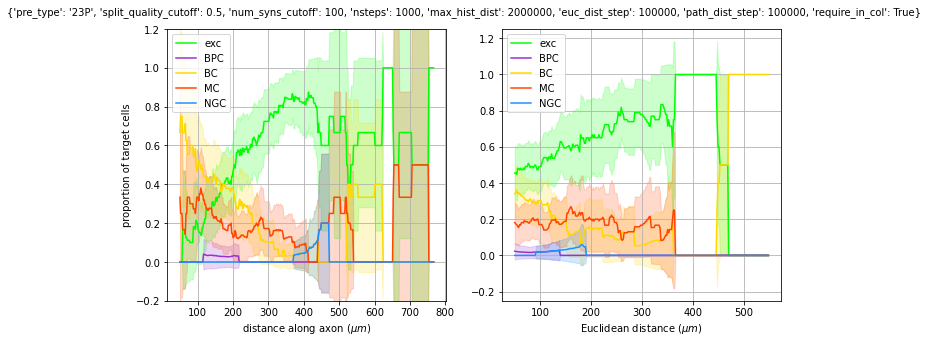

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for cell_type in syn_dfs:
    p = p_type_by_path_dists[cell_type]
    axes[0].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    std_hat = np.sqrt(p * (1 - p) / (path_dist_step * path_total_density))
    axes[0].fill_between(path_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("proportion of target cells")
axes[0].legend()
axes[0].grid()
for cell_type in syn_dfs:
    p = p_type_by_euc_dists[cell_type]
    axes[1].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    sem = np.sqrt(p * (1 - p) / (euc_dist_step * euc_total_density))
    axes[1].fill_between(euc_bin_locs/1000, p - 2 * sem, p + 2 * sem, color=type_colors[cell_type], alpha=0.2)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
axes[0].set_ylim((-0.2, 1.2))
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [133]:
fig.savefig(os.path.join(results_dir, results_fname + "_p_type.png"))

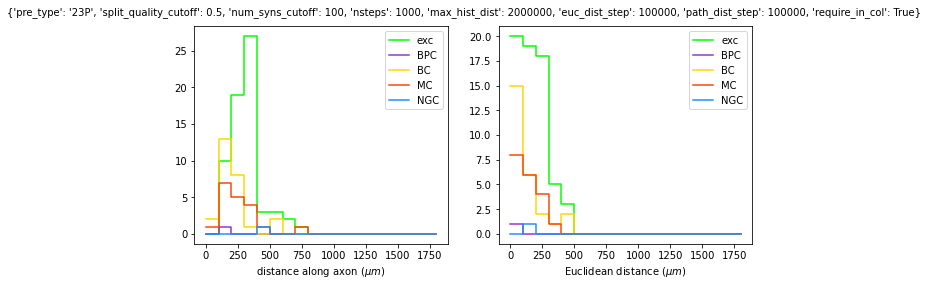

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in syn_dfs:
    axes[0].step(path_bin_edges[:-1]/1000, path_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].step(euc_bin_edges[:-1]/1000, euc_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [135]:
fig.savefig(os.path.join(results_dir, results_fname + "_hists.png"))

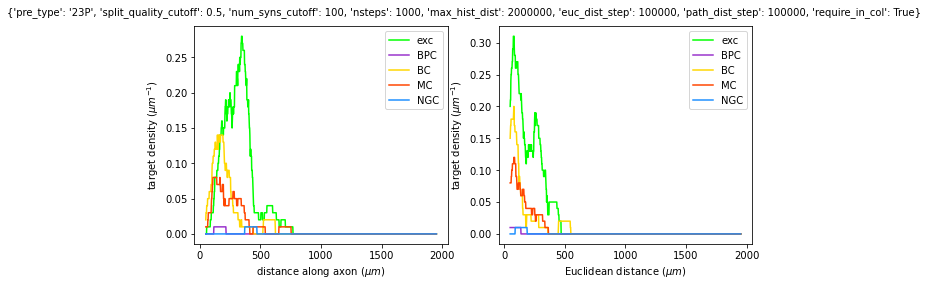

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in syn_dfs:
    axes[0].plot(path_bin_locs/1000, 1000*path_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("target density ($\mu m^{-1}$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].plot(euc_bin_locs/1000, 1000*euc_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("target density ($\mu m^{-1}$)")
axes[1].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [137]:
fig.savefig(os.path.join(results_dir, results_fname + "_densities.png"))

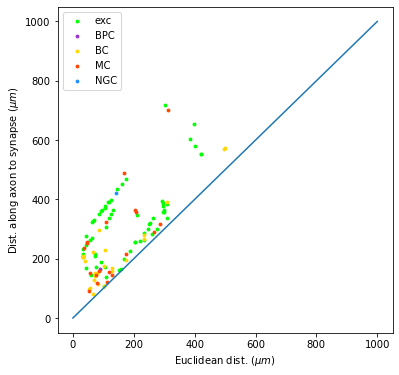

In [138]:
# plot euclidean distance to synapse vs path distance to synapse
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].euc_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.plot([0, 1000], [0, 1000])
ax.set_xlabel("Euclidean dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [139]:
fig.savefig(os.path.join(results_dir, results_fname + "_euc_v_path.png"))

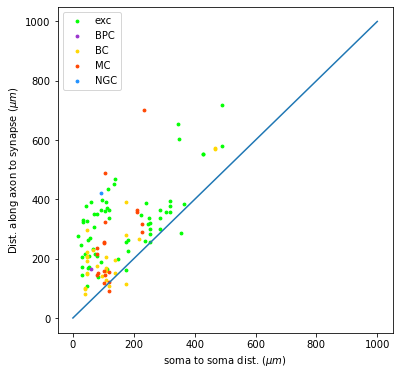

In [140]:
# plot path-distance along axon to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.plot([0, 1000], [0, 1000])
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [141]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_path.png"))

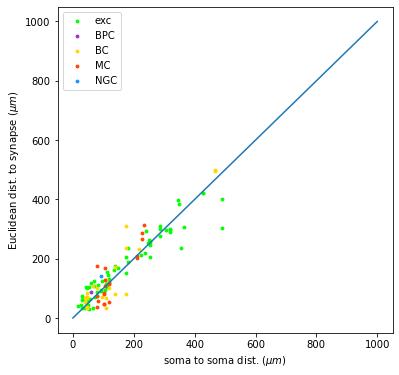

In [142]:
# plot euclidean distance to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].euc_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.plot([0, 1000], [0, 1000])
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Euclidean dist. to synapse ($\mu m$)")
plt.legend()
plt.show()

In [143]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_euc.png"))

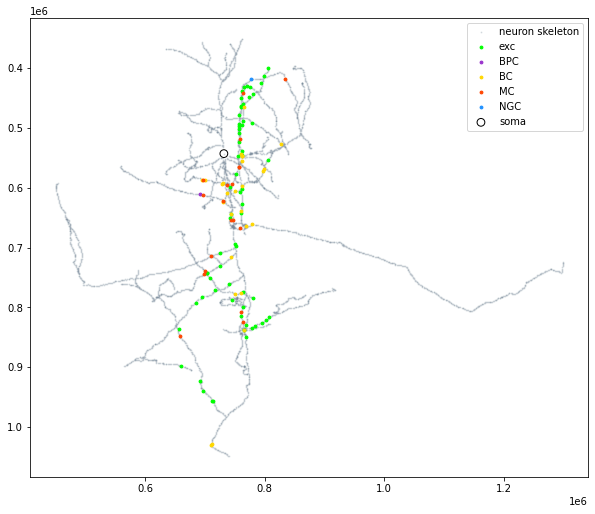

In [144]:
# plot the skeleton
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect(1)
ax.scatter(skel_vertices[:, 0], skel_vertices[:, 1], s=1, alpha=.2, c="lightslategrey", label="neuron skeleton")
for cell_type in syn_dfs:
    syn_locs = syn_dfs[cell_type].pre_pt_position.apply(vx_to_nm).values
    if len(syn_locs) > 0:
        syn_locs = np.stack(syn_locs)
        ax.scatter(syn_locs[:, 0], syn_locs[:, 1], s=8, c=type_colors[cell_type], alpha=1, label=cell_type)
ax.scatter(soma_loc[0], soma_loc[1], s=60, marker="o", facecolors='none', edgecolors='k', label="soma")
ax.invert_yaxis()
plt.legend()
plt.show()

In [145]:
fig.savefig(os.path.join(results_dir, results_fname + "_skeleton.png"))